In [1]:
import torch 
import numpy as np

import os 
import glob
import json
import csv
import sys

import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import models.trainer as trainer
import models.hfno_1D_w as hfno
import models.fno_1D as fno
from torch.utils.data import DataLoader, TensorDataset #to manage datasets and bash 

In [72]:
fno_model = torch.load(os.path.join(os.path.abspath(''), "trained_models/fno_classic/model_1.pt"))
hfno_model = torch.load(os.path.join(os.path.abspath(''), "trained_models/fno/model_25.pt"))

/var/folders/53/d3ng48y138s7ldywsyn64jj00000gn/T/ipykernel_92357/2652849300.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fno_model = torch.load(os.path.join(os.path.a

In [115]:
num_models = [24,25,26,27,28]
n_layers = [1,2,4,8,16]

In [116]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(fno_model), count_parameters(hfno_model)

(69953, 82989)

In [117]:
def grid_encoding(functions, x_coordinates, encoding_dimension):
    """ 
    This function reduces the size of a the input tensor functions and the corresponding x_coordinates to a lower size (encodinf_dimension) according the x dimension

    :param functions: this is a tensor of dimension (P, M) representing a 1D function u evolving through time, each coordinate (i,j) corresponds to a location x_i and a time t_j i.e function[i,j] = u(x_i, t_j)
    :param x_coordinates: this is a tensor of dimension (P,) representing the points (x_i) where the function u has been evaluated.
    :param encoding_dimension: this is an integer descibing the new size of the x axis 

    :return encoding_coordinates: tensor of dimension (encoding_dimension,) representing the x points where the functions is now evaluated
    :return encoded_functions: tensor of dimension (encoding_dimension, M) representing the functions on a lower space.
    """
    P = functions.shape[0]
    M = functions.shape[1]
    
    idx = np.linspace(0, P-1, encoding_dimension)
    encoded_functions = functions[idx, :]
    encoding_coordinates = x_coordinates[idx]
    
    return encoding_coordinates, encoded_functions


In [125]:
m = 256
nu = 0.7


data = torch.from_numpy(np.load(os.path.join(os.path.abspath(''), "../data/ks_equation/data_"+str(int(100*nu))+".npy"))).type(torch.float32)
mat_deriv = torch.from_numpy(np.load(os.path.join(os.path.abspath(''), "../data/ks_equation/mat_deriv_"+str(int(100*nu))+".npy"))).type(torch.float32)
grid_carac = torch.from_numpy(np.load(os.path.join(os.path.abspath(''), "../data/ks_equation/grid_"+str(int(100*nu))+".npy"))).type(torch.float32)
nt, dt, Tf, Mx, dx, L = grid_carac
u_train = data[:,100:]
mat_deriv_train = mat_deriv[:,100:]

x_coordinates = torch.arange(0., Mx)*dx # reconstruction of the vector encoding the coordinates used for x

n_train = u_train.shape[1]

x_encoded, encoded_input_train = grid_encoding(u_train, x_coordinates, encoding_dimension=m)
encoded_input_train = encoded_input_train.T

_, encoded_output_train = grid_encoding(mat_deriv_train, x_coordinates, encoding_dimension=m)
encoded_output_train = encoded_output_train.T


data = torch.from_numpy(np.load(os.path.join(os.path.abspath(''), "../data/ks_equation/data_"+str(int(100*nu))+"_test.npy"))).type(torch.float32)
mat_deriv = torch.from_numpy(np.load(os.path.join(os.path.abspath(''), "../data/ks_equation/mat_deriv_"+str(int(100*nu))+"_test.npy"))).type(torch.float32)
grid_carac = torch.from_numpy(np.load(os.path.join(os.path.abspath(''), "../data/ks_equation/grid_"+str(int(100*nu))+"_test.npy"))).type(torch.float32)
nt, dt, Tf, Mx, dx, L = grid_carac
u_test = data[:,100:]
mat_deriv_test = mat_deriv[:,100:]

x_coordinates = torch.arange(0., Mx)*dx # reconstruction of the vector encoding the coordinates used for x

n_test = u_test.shape[1]

_, encoded_input_test = grid_encoding(u_test, x_coordinates, encoding_dimension=m)
encoded_input_test = encoded_input_test.T

_, encoded_output_test = grid_encoding(mat_deriv_test, x_coordinates, encoding_dimension=m)
encoded_output_test = encoded_output_test.T



In [126]:
rel_train_error = []
rel_test_error = []
for num_model in num_models:
    hfno_model = torch.load(os.path.join(os.path.abspath(''), "trained_models/fno/model_"+str(num_model)+".pt"))
    print(f"Evaluating model {num_model}...")
    hfno_model.eval()
    preds_train = hfno_model(encoded_input_test)
    preds_test = hfno_model(encoded_input_train)
    train_error = torch.mean(torch.sqrt(torch.sum((preds_train - encoded_output_test)**2, dim=1) / torch.sum(encoded_output_test**2, dim=1))).item()
    test_error = torch.mean(torch.sqrt(torch.sum((preds_test - encoded_output_train)**2, dim=1) / torch.sum(encoded_output_train**2, dim=1))).item()
    rel_train_error.append(train_error)
    rel_test_error.append(test_error)
preds_fno_train = fno_model(encoded_input_test)
preds_fno_test = fno_model(encoded_input_train)
fno_train_error = torch.mean(torch.sqrt(torch.sum((preds_fno_train - encoded_output_test)**2, dim=1) / torch.sum(encoded_output_test**2, dim=1))).item()
fno_test_error = torch.mean(torch.sqrt(torch.sum((preds_fno_test - encoded_output_train)**2, dim=1) / torch.sum(encoded_output_train**2, dim=1))).item()


/var/folders/53/d3ng48y138s7ldywsyn64jj00000gn/T/ipykernel_92357/3582750741.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hfno_model = torch.load(os.path.join(os.path.

Evaluating model 24...
Evaluating model 25...
Evaluating model 26...
Evaluating model 27...
Evaluating model 28...


In [120]:
rel_test_error

[0.16350986063480377,
 0.10868898779153824,
 0.11257314682006836,
 0.12913528084754944,
 0.13280384242534637]

Text(0.5, 0, 'Number of layers')

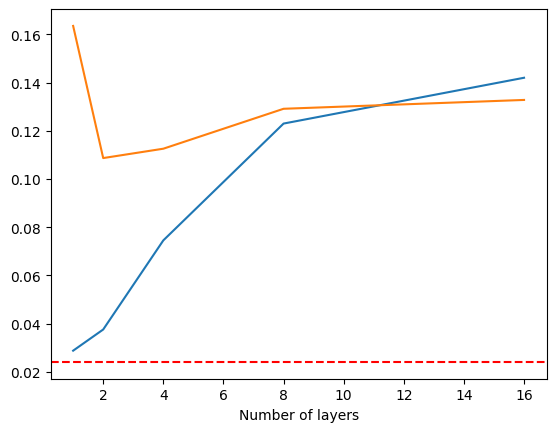

In [135]:
plt.axhline(y=fno_train_error, color='r', linestyle='--')
plt.plot(n_layers,rel_train_error)
plt.plot(n_layers,rel_test_error)
plt.xlabel("Number of layers")



k_L = 0.768875022766068
k_nu = 2.643103304394167


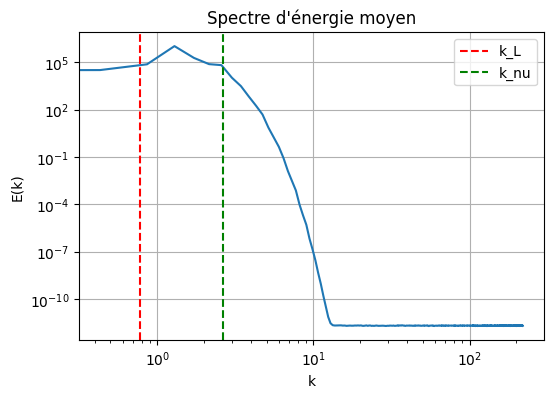

In [46]:
import numpy as np

# u : array(nt, nx)
u = u_train.T

nt, nx = u.shape

kx = 2 * np.pi * np.fft.rfftfreq(nx, d=dx.item())*1.5  # taille nx     

# FFT spatiale
u_hat = np.fft.rfft(u, axis=1)

# Spectre d'énergie moyen
E_k = np.mean(np.abs(u_hat)**2, axis=0)    # moyenne sur le temps

# Ignorer k=0 pour éviter division par zéro

k_L = np.sum(E_k[1:]/kx[1:]) / np.sum(E_k)

# Calcul du nombre d'onde dissipatif k_nu
k_nu = np.sqrt(np.sum((kx**4) * E_k) / np.sum(E_k))

print("k_L =", k_L)
print("k_nu =", k_nu)

# Trace du spectre pour vérification
plt.figure(figsize=(6,4))
plt.loglog(np.abs(kx), E_k)
plt.xlabel("k")
plt.ylabel("E(k)")
plt.title("Spectre d'énergie moyen")
plt.grid(True)

plt.axvline(k_L, color='r', linestyle='--', label='k_L')
plt.axvline(k_nu, color='g', linestyle='--', label='k_nu')
plt.legend()

plt.show()